In [ ]:
import pandas as pd
import numpy as np
import torch
import random
import re
from collections import Counter
import tensorflow as tf

import matplotlib.pyplot as plt
from imblearn.under_sampling import NearMiss

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import nltk
from nltk.tokenize import word_tokenize

from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Embedding, Dropout, LSTM, TimeDistributed, Input, GRU
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.sequence import pad_sequences

##Часть 1.

###Задание 1.

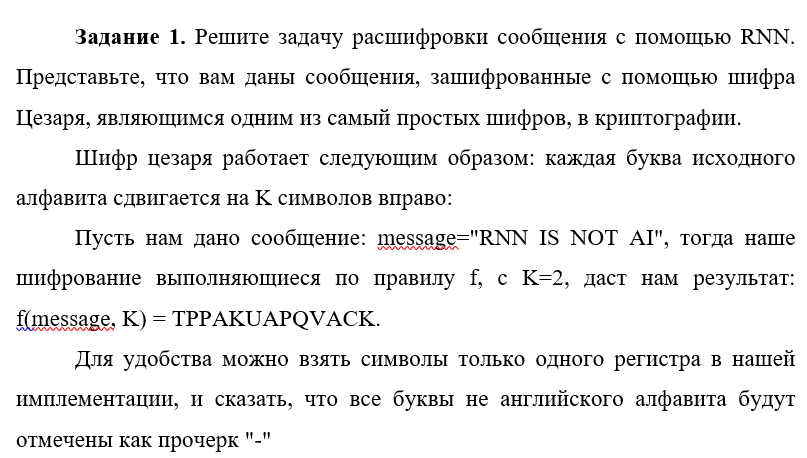

####Шифр Цезаря

In [ ]:
key = 2
v_string = ' ABCDEFGHIJKLMNOPQRSTUVWXYZ'
vocab = dict(zip([char for char in v_string], [i for i in range(len(v_string))]))
message = "RNN IS точно NOT AI"

In [ ]:
def tokenizer(text, vocab=vocab):
    indexes = [vocab.get(text[i]) for i in range(len(text))]
    return indexes

In [ ]:
def encrypt(text, key, vocab=vocab):
  indexes = tokenizer(text, vocab=vocab)
  encrypted_text = [list(vocab.keys())[(ind+key)% len(vocab)] if ind in vocab.values() else '-' for ind in indexes]
  return encrypted_text

def encrypt_data(x, key, vocab=vocab):
  if isinstance(x, list):
    encrypted_data = [encrypt(string, key, vocab) for string in x]
  elif isinstance(x, str):
    encrypted_data = encrypt(x, key, vocab)
  else:
    encrypted_data = [0]
  return encrypted_data

In [ ]:
example = encrypt_data(message, key)
''.join(example)

'TPPBKUB-----BPQVBCK'

####Дешифрование с помощью RNN

##### Подготовка данных

In [ ]:
def RNNcleanalyzer(text):
    text = text.upper()
    text = re.sub('[^A-Z]', ' ', text)
    text = ''.join(text)
    return text

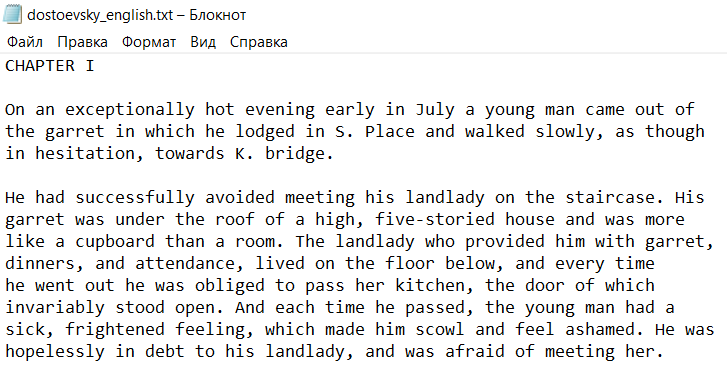

In [ ]:
k = 2
plaintext = []
codes = []
with open("/content/dostoevsky_english.txt", mode='r', encoding='utf-8-sig') as f:
  for line in f.readlines():
    if line != '\n':
      plaintext.append(RNNcleanalyzer(line))
      codes.append(encrypt_data(RNNcleanalyzer(line), k))
for i in range(5):
  print(f'Текст:{plaintext[i]}\nКод:{codes[i]}')


Текст:CHAPTER I 
Код:['E', 'J', 'C', 'R', 'V', 'G', 'T', 'B', 'K', 'B']
Текст:ON AN EXCEPTIONALLY HOT EVENING EARLY IN JULY A YOUNG MAN CAME OUT OF 
Код:['Q', 'P', 'B', 'C', 'P', 'B', 'G', 'Z', 'E', 'G', 'R', 'V', 'K', 'Q', 'P', 'C', 'N', 'N', ' ', 'B', 'J', 'Q', 'V', 'B', 'G', 'X', 'G', 'P', 'K', 'P', 'I', 'B', 'G', 'C', 'T', 'N', ' ', 'B', 'K', 'P', 'B', 'L', 'W', 'N', ' ', 'B', 'C', 'B', ' ', 'Q', 'W', 'P', 'I', 'B', 'O', 'C', 'P', 'B', 'E', 'C', 'O', 'G', 'B', 'Q', 'W', 'V', 'B', 'Q', 'H', 'B']
Текст:THE GARRET IN WHICH HE LODGED IN S  PLACE AND WALKED SLOWLY  AS THOUGH 
Код:['V', 'J', 'G', 'B', 'I', 'C', 'T', 'T', 'G', 'V', 'B', 'K', 'P', 'B', 'Y', 'J', 'K', 'E', 'J', 'B', 'J', 'G', 'B', 'N', 'Q', 'F', 'I', 'G', 'F', 'B', 'K', 'P', 'B', 'U', 'B', 'B', 'R', 'N', 'C', 'E', 'G', 'B', 'C', 'P', 'F', 'B', 'Y', 'C', 'N', 'M', 'G', 'F', 'B', 'U', 'N', 'Q', 'Y', 'N', ' ', 'B', 'B', 'C', 'U', 'B', 'V', 'J', 'Q', 'W', 'I', 'J', 'B']
Текст:IN HESITATION  TOWARDS K  BRIDGE  
Код:['K', 'P', 'B

In [ ]:
def padding(ds, length=None):
  if length is None:
        length = max([len(sentence) for sentence in ds])
  return pad_sequences(ds, maxlen=length, padding="post", truncating="post",)

In [ ]:
def preprocess(x, y):
  preprocess_x = [tokenizer(i) for i in x]
  preprocess_y = [tokenizer(j) for j in y]

  preprocess_x = padding(preprocess_x)
  preprocess_y = padding(preprocess_y)

  preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

  return preprocess_x, preprocess_y

In [ ]:
preprocessed_pt, preprocessed_c = preprocess(plaintext, codes)
preprocessed_pt[:3]

array([[ 3,  8,  1, 16, 20,  5, 18,  0,  9,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [15, 14,  0,  1, 14,  0,  5, 24,  3,  5, 16, 20,  9, 15, 14,  1,
        12, 12, 25,  0,  8, 15, 20,  0,  5, 22,  5, 14,  9, 14,  7,  0,
         5,  1, 18, 12, 25,  0,  9, 14,  0, 10, 21, 12, 25,  0,  1,  0,
        25, 15, 21, 14,  7,  0, 13,  1, 14,  0,  3,  1, 13,  5,  0, 15,
        21, 20,  0, 15,  6,  0,  0,  0,  0,  0],
       [20,  8,  5,  0,  7,  1, 18, 18,  5, 20,  0,  9, 14,  0, 23,  8,
         9,  3,  8,  0,  8,  5,  0, 12, 15,  4,  7,  5,  4,  0,  9, 14,
         0, 19,  0,  0, 16, 12,  1,  3,  5,  0,  1, 14,  4,  0, 23,  1,
        12, 11,  5,  4,  0, 19, 12, 15, 23, 12, 25,  0,  0,  1, 19,  0,
        20,  8, 15, 21,  7,  8,  0,  0

In [ ]:
def decrypt(digits, vocab=vocab):
    text = ''
    for dig in digits:
      for alpha, ind in vocab.items():
        if int(ind) == int(dig):
          text += alpha
    return text

In [ ]:
decrypt(preprocessed_pt[0])

'CHAPTER I                                                                 '

#####Модель

In [ ]:
def rnn_model(input_shape, output_sequence_length, vocab_size):
    learning_rate = 0.001
    input_seq = Input(input_shape[1:])
    rnn = GRU(64, return_sequences=True)(input_seq)
    logits = TimeDistributed(Dense(vocab_size))(rnn)

    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

tmp_x = padding(preprocessed_c, preprocessed_pt.shape[1])
tmp_x = tmp_x.reshape((-1, preprocessed_c.shape[-2], 1))

In [ ]:
caesar_rnn_model = rnn_model(
    tmp_x.shape,
    preprocessed_pt.shape[1],
    len(vocab)+1)

In [ ]:
history = caesar_rnn_model.fit(tmp_x, preprocessed_pt, batch_size=32, epochs=150, validation_split=0.2)

Epoch 1/150
34/34 [==============================] - 4s 39ms/step - loss: 2.8276 - accuracy: 0.2976 - val_loss: 2.3998 - val_accuracy: 0.3182
Epoch 2/150
34/34 [==============================] - 1s 28ms/step - loss: 2.0894 - accuracy: 0.4119 - val_loss: 2.0188 - val_accuracy: 0.4180
Epoch 3/150
34/34 [==============================] - 1s 30ms/step - loss: 1.7884 - accuracy: 0.4814 - val_loss: 1.8192 - val_accuracy: 0.4621
Epoch 4/150
34/34 [==============================] - 1s 40ms/step - loss: 1.6285 - accuracy: 0.5217 - val_loss: 1.6726 - val_accuracy: 0.4915
Epoch 5/150
34/34 [==============================] - 1s 30ms/step - loss: 1.5015 - accuracy: 0.5452 - val_loss: 1.5499 - val_accuracy: 0.5194
Epoch 6/150
34/34 [==============================] - 1s 28ms/step - loss: 1.3940 - accuracy: 0.5565 - val_loss: 1.4454 - val_accuracy: 0.5149
Epoch 7/150
34/34 [==============================] - 1s 26ms/step - loss: 1.3019 - accuracy: 0.5751 - val_loss: 1.3545 - val_accuracy: 0.5478
Epoch 

#####Результаты


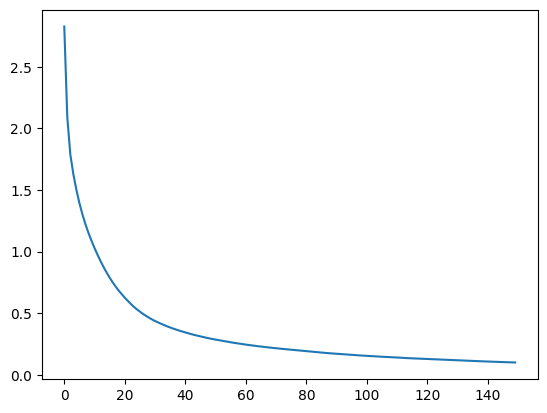

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
print(f"Точность модели по завершению обучения: {history.history['accuracy'][-1]:.2f}")

Точность модели по завершению обучения: 0.98


In [ ]:
decrypt(np.argmax(caesar_rnn_model.predict(tmp_x[:1])[0], 1))

1/1 [==============================] - 0s 27ms/step


'CHAPTER I Y                                                               '

###Задание 2.

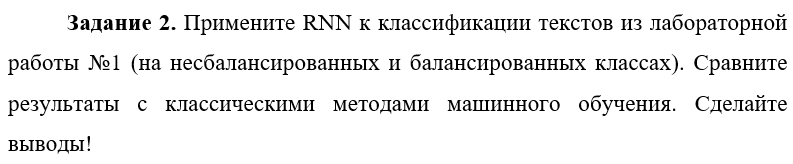

In [ ]:
df = pd.read_csv('reviews.csv', index_col=0)
df[['review_name', 'review_body']] = df[['review_name', 'review_body']].applymap(lambda x: np.str_(x))
df['review_rate'] = df['review_rate'].apply(lambda x: np.float_(x))

In [ ]:
df.head()

,review_name,review_rate,review_body
0,возникл вопрос повод оформлен карт,5.0,обрат сообществ альфа-банк социальн сет пробле...
1,оп общен специалист альфа-банк,5.0,октябр написа мобильн приложен поинтересова см...
2,консультац услов вклад,4.0,позвон банк приложен личн кабинет альфа-банк н...
3,кешбек оплат alfa,5.0,октябр реш написа поддержк узна работа кешбек ...
4,подсказа льготн период,5.0,добр ден сегодн октябр обрат поддержк альфа-ба...


####Несбалансированные классы

In [ ]:
vectorizer_name = TfidfVectorizer()
vectorizer_body = TfidfVectorizer()

In [ ]:
y = df['review_rate']
X_name = vectorizer_name.fit_transform(df['review_name'])
X_1 = pd.DataFrame(X_name.toarray(), columns=vectorizer_name.get_feature_names_out())
X_body = vectorizer_body.fit_transform(df['review_body'])
X_2 = pd.DataFrame(X_body.toarray(), columns=vectorizer_body.get_feature_names_out())

In [ ]:
X = pd.concat([X_1, X_2], axis=1)
y.shape, X.shape

((2000,), (2000, 9854))

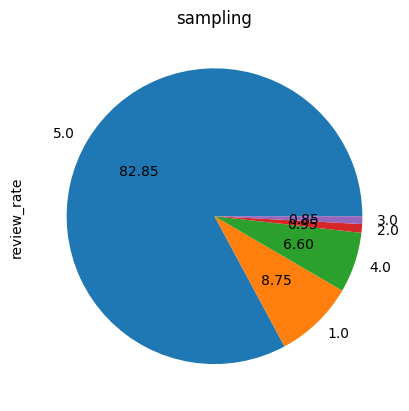

In [ ]:
ax = y.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("sampling")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
y_trainmatrix = tf.keras.utils.to_categorical(y_train, 6)
y_valmatrix = tf.keras.utils.to_categorical(y_test, 6)

max_features = 1000
embedding_vector_length = 200
max_sequense_length = 32

model=Sequential(
    [
        Embedding(max_features, embedding_vector_length),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(6, activation='softmax')
    ]
)
optimzer = Adam(clipvalue=0.5)

model.compile(optimizer=optimzer,
                  loss='categorical_crossentropy',
                  metrics=[tf.keras.metrics.AUC()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         200000    
                                                                 
 dropout (Dropout)           (None, None, 200)         0         
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 268230 (1.02 MB)
Trainable params: 268230 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history=model.fit(X_train, y_trainmatrix,
                  batch_size=64,
                  epochs=2,
                  validation_data=(X_test, y_valmatrix),
                  verbose=1)

Epoch 1/2
22/22 [==============================] - 759s 34s/step - loss: 1.0625 - auc: 0.9037 - val_loss: 0.7375 - val_auc: 0.9342
Epoch 2/2
22/22 [==============================] - 731s 33s/step - loss: 0.6525 - auc: 0.9434 - val_loss: 0.6737 - val_auc: 0.9350


In [ ]:
print(r'the final accuracy for RNN model (not balanced classes) is: ', round(history.history['auc'][-1], 2))

the final accuracy for RNN model (not balanced classes) is:  0.94


Результаты обучения классических моделей приведены ниже. Как можно заметить, за две эпохи обучения модели RNN она превзошла самую точную из классических моделей.

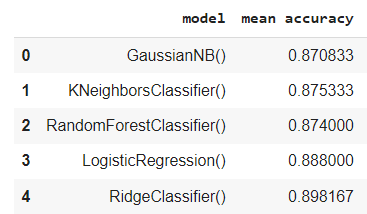

####Сбалансированные классы

In [ ]:
nm = NearMiss()
X_miss, y_miss = nm.fit_resample(X, y)
X_miss.shape, y_miss.shape

((85, 9854), (85,))

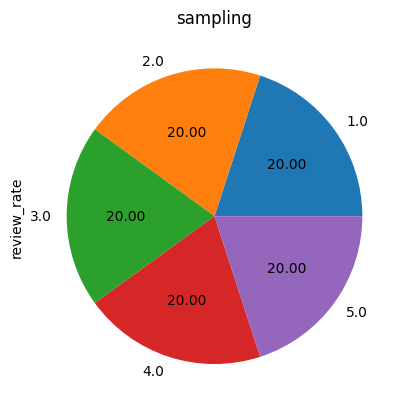

In [ ]:
ax = y_miss.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("sampling")

In [ ]:
X_train_miss, X_test_miss, y_train_miss, y_test_miss = train_test_split(X_miss, y_miss, random_state = 42, test_size = 0.2)
y_trainmatrix_miss = tf.keras.utils.to_categorical(y_train_miss, 6)
y_valmatrix_miss = tf.keras.utils.to_categorical(y_test_miss, 6)

In [ ]:
history=model.fit(X_train_miss, y_trainmatrix_miss,
                  batch_size=64,
                  epochs=20,
                  validation_data=(X_test_miss, y_valmatrix_miss),
                  verbose=1)

Epoch 1/20
2/2 [==============================] - 50s 19s/step - loss: 2.0789 - auc: 0.6032 - val_loss: 1.8629 - val_auc: 0.6353
Epoch 2/20
2/2 [==============================] - 48s 16s/step - loss: 1.9521 - auc: 0.6144 - val_loss: 1.7873 - val_auc: 0.6353
Epoch 3/20
2/2 [==============================] - 48s 17s/step - loss: 1.9295 - auc: 0.5813 - val_loss: 1.7334 - val_auc: 0.6353
Epoch 4/20
2/2 [==============================] - 47s 18s/step - loss: 1.8079 - auc: 0.6079 - val_loss: 1.6949 - val_auc: 0.6353
Epoch 5/20
2/2 [==============================] - 46s 17s/step - loss: 1.7805 - auc: 0.5948 - val_loss: 1.6710 - val_auc: 0.6353
Epoch 6/20
2/2 [==============================] - 49s 18s/step - loss: 1.7258 - auc: 0.6082 - val_loss: 1.6587 - val_auc: 0.6353
Epoch 7/20
2/2 [==============================] - 48s 17s/step - loss: 1.7192 - auc: 0.5910 - val_loss: 1.6530 - val_auc: 0.6353
Epoch 8/20
2/2 [==============================] - 47s 18s/step - loss: 1.7198 - auc: 0.5800 - val

In [ ]:
print(r'the final accuracy for RNN model (balanced classes) is: ', round(history.history['auc'][-1], 2))

the final accuracy for RNN model (balanced classes) is:  0.56


####Выводы

На несбалансированных классах модель показала себя очень хорошо, обогнав по точности все использованные классические модели. Однако только на сбалансированных она выдает точность 0.56, что говорит о недообученности модели.\
Причина недообученности состоит в том, что, как видно на общей диаграмме распределения классов из всей выборки, класс "3" (самый редко встречающийся класс) занимает лишь 0.85% от всей выборки из 2000 элементов. При балансировки классов это учитывается, и берется соответствующее количество экземпляров каждого класса (0.85% от 2000 это 17 элементов), подтверждение этому можно заметить при вызове размеров y_miss (85 элементов это 5*17 классов).\
Решить эту проблему можно разными методами:

1.   Взять большее количество данных из источника (к примеру, 3000)
2.   "Искусственно" или вручную добавить экземпляры к классам в меньшинстве.

Итого можно сделать вывод, что RNN (в частности, LSTM благодаря хранению долгосрочных зависимостей) отлично показала себя в работе с текстовыми данными.



###Задание 3.

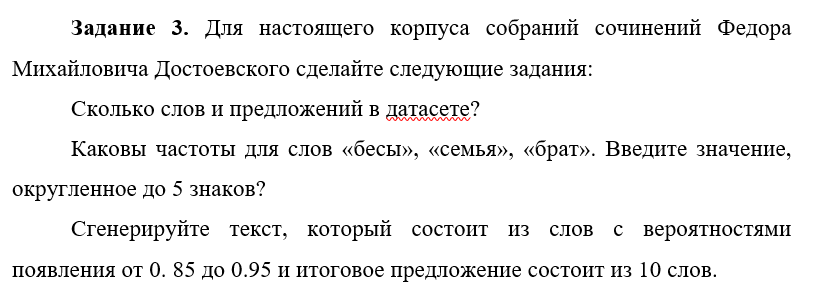

In [ ]:
def cleanalyzer(text):
    text = (re.sub(r'[A-Za-z0-9\\]', ' ', text)).lower()
    text = text.split()
    text = [word for word in text if len(word) > 2]
    text = ' '.join(text)
    return text

In [ ]:
dostoevsky = ''
with open("/content/dostoevsky.txt", mode='r', encoding='utf-8-sig') as f:
  for line in f.readlines():
    dostoevsky += cleanalyzer(line) + " "
dostoevsky[:255]

'федор михайлович достоевский бедные люди эти мне сказочники! нет чтобы написать что-нибудь полезное, приятное, усладительное, всю подноготную земле вырывают!.. вот запретил писать! ну, что это похоже: читаешь… невольно задумываешься, там всякая дребедень '

In [ ]:
symbols = r'[.|!|?|…|,]'
tokenized_dostoevsky = word_tokenize(dostoevsky)
tokenized_dostoevsky = [i for i in tokenized_dostoevsky if i not in symbols]
tokenized_dostoevsky[:10]

['федор',
 'михайлович',
 'достоевский',
 'бедные',
 'люди',
 'эти',
 'мне',
 'сказочники',
 'нет',
 'чтобы']

In [ ]:
symbols = r'[.|!|?|…]'
sentences = [i.lstrip() for i in re.split(symbols, dostoevsky) if i]
sentences[:3]

['федор михайлович достоевский бедные люди эти мне сказочники',
 'нет чтобы написать что-нибудь полезное, приятное, усладительное, всю подноготную земле вырывают',
 'вот запретил писать']

Сколько слов и предложений в датасете?


In [ ]:
print(f"Количество слов в датасете: {len(tokenized_dostoevsky)}\nКоличество предложений в датасете: {len(sentences)}")

Количество слов в датасете: 1419300
Количество предложений в датасете: 137494


Каковы частоты для слов бесы, семья, брат?

In [ ]:
print(f"Для слова бесы: {counter['бесы']/counter.total():.5f}\n"\
      f"Для слова семья: {counter['семья']/counter.total():.5f}\n"\
      f"Для слова брат: {counter['брат']/counter.total():.5f}")

Для слова бесы: 0.00001
Для слова семья: 0.00002
Для слова брат: 0.00039


##Часть 2.

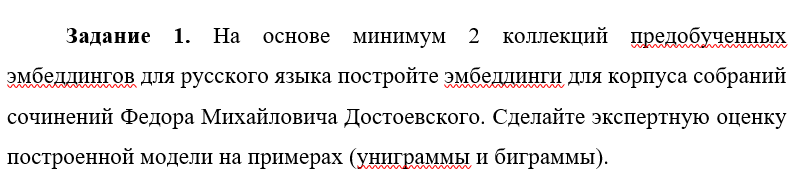